# Risoluzione del problema di TSP mediante algoritmo di Tabu Search

Martedì Gaetano M63001226

Salzillo Biagio M63001227

## Librerie

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import time
import matplotlib.pyplot as plt

## Definizione degli algoritmi di Tabu Search

Definiamo le classi Python che implementano l'algoritmo di Tabu Search, sia in una versione "pura", ovvero senza applicare il meccanismo di diversificazione, e sia nella versione con diversificazione LFU (Least Frequently Used)

### Tabu Search Puro

In [2]:
class TabuSearch:
    
    #carico la lista di nodi del problema e il dizionario contenente le distanze sugli archi
    def __init__(self, nodi, dist_dic):
        self.nodi = nodi
        self.dist = dist_dic
        self.num_nodi = len(nodi)
    
    #funzione che calcola il valore della funzione obiettivo
    def fun_obj(self,sol):
        somma = 0
        for i in range(self.num_nodi):
            somma += self.dist[(sol[i],sol[(i+1) % self.num_nodi])]
        return somma
    
    #funzione che implementa la greedy Nearest Neighbour
    def sol_iniziale(self):
        s = [self.nodi[0]]
        temp = self.nodi[1:]
        for k in range(1, self.num_nodi):
            min_dist = float('inf')
            for i in temp:
                if self.dist[(s[k-1],i)] < min_dist :
                    min_dist = self.dist[(s[k-1],i)]
                    minimo = i
            s.append(minimo)
            temp.remove(minimo)
            
        self.update_sol_visitated(s)
        return s
        
    #funzione che implementa la mossa 2-opt
    def mossa2opt(self,sol):
        minimo = float('inf')
        for i in range(1, self.num_nodi-1):
            for k in range(i+1, self.num_nodi if i > 1 else (self.num_nodi - 1)):
                temp_sol = sol[:i] + (sol[i:k+1])[::-1] + sol[k+1:]
                v = self.fun_obj(temp_sol)
                self.update_sol_visitated(temp_sol)
                if v < minimo:
                    if self.check_lista_tabu((i,k), v) :
                        minimo = v
                        new_sol = temp_sol[:]
                        mossa = (i,k)
        
        return new_sol, mossa
    
    #controlla se una mossa è tabu e, in tal caso, se essa rispetta il criterio di aspirazione
    def check_lista_tabu(self, mossa, val_mossa):
        if mossa in self.lista_tabu and val_mossa >= self.val_ottimo :
            return False
        else:
            return True
    
    #inserisce la mossa nella lista tabu
    def aggiorna_lista_tabu(self, mossa):
        self.lista_tabu.append(mossa)
        if self.lun_att_tabu < self.lun_max_tabu :
            self.lun_att_tabu += 1
        else:
            self.lista_tabu.pop(0)
                
    #controlla se una data soluzione ha un valore di funzione obiettivo migliore dell'ottimo attuale
    def check_ottimo(self,sol):
        v = self.fun_obj(sol)
        if v < self.val_ottimo:
            self.val_ottimo = v
            self.sol_ottima = sol
            return True
        else:
            return False
        
    def update_sol_visitated(self,sol):
        self.sol_visitated.add(tuple(sol))
      
    #funzione per la risoluzione del problema di TSP settando i parametri:
    # - lunghezza lista tabu
    # - num. di iterazioni inconcludenti (dopo cui terminare)
    def resolve(self, num_iter_inc, lun_lista_tabu) :       
        self.lun_max_tabu = lun_lista_tabu
        self.lista_tabu = []
        self.lun_att_tabu = 0
        self.sol_visitated = set()
        
        s = self.sol_iniziale()
        self.sol_ottima = s
        self.val_ottimo = self.fun_obj(s)
        
        i = 0
        
        while i < num_iter_inc :
            s, mossa = self.mossa2opt(s)
            self.aggiorna_lista_tabu(mossa)
            if self.check_ottimo(s):
                i = 0
            else:
                i += 1
        
        return (self.sol_ottima,self.val_ottimo), len(self.sol_visitated)
        


### Tabu Search con diversificazione LFU

In [3]:
class TabuSearchLFU(TabuSearch):
    
    #implementazione del meccanismo di diversificazione
    def diversificazione(self,sol):
        sort_list = sorted(self.dic_freq.items(), key = lambda x: x[1])
        
        #sort_list è la lista delle mosse ordinata in ordine crescente di frequenza
        mossa = sort_list.pop(0)[0]
        while mossa in self.lista_tabu:
            mossa = sort_list.pop(0)[0]
        i = mossa[0]
        k = mossa[1]
        sol = sol[:i] + (sol[i:k+1])[::-1] + sol[k+1:]
        self.check_ottimo(sol)
        self.update_sol_visitated(sol)
        self.aggiorna_lista_tabu(mossa)
        self.aggiorna_dic_freq(mossa)

        return sol
            
    #aggiornamento della frequena di una data mossa
    def aggiorna_dic_freq(self,mossa):
        self.dic_freq[mossa] += 1
        
    #inizializzazione del dizionario delle frequenze a zero per tutte le mosse 2-opt effettuabili 
    def init_dic_freq(self):
        for i in range(1, self.num_nodi-1):
            for k in range(i+1, self.num_nodi if i > 1 else (self.num_nodi - 1)):
                self.dic_freq[(i,k)] = 0
    
    #funzione per la risoluzione del problema di TSP, settando i parametri:
    # - lunghezza lista tabu
    # - num. di iterazioni inconcludenti
    # - num. di diversificazioni
    def resolve(self, num_iter_inc, num_divers, lun_lista_tabu):
        self.lun_max_tabu = lun_lista_tabu
        self.lista_tabu = []
        self.lun_att_tabu = 0
        self.dic_freq = {}
        self.sol_visitated = set()
        self.init_dic_freq()
        
        s = self.sol_iniziale()
        self.sol_ottima = s
        self.val_ottimo = self.fun_obj(s)
        
        t = 0  #variabile per il conteggio delle diverificazioni
        i = 0  #variabile per il conteggio delle iterazioni inconcludenti
        
        while t < num_divers :
            while i < num_iter_inc :
                s, mossa = self.mossa2opt(s)
                self.aggiorna_lista_tabu(mossa)
                self.aggiorna_dic_freq(mossa)
                if self.check_ottimo(s):
                    i = 0
                else:
                    i += 1  
            s = self.diversificazione(s)
            self.check_ottimo(s)
            i = 0
            t += 1
        
        while i < num_iter_inc :
                s, mossa = self.mossa2opt(s)
                self.aggiorna_lista_tabu(mossa)
                self.aggiorna_dic_freq(mossa)
                if self.check_ottimo(s):
                    i = 0
                else:
                    i += 1 
        
        return (self.sol_ottima,self.val_ottimo), len(self.sol_visitated)

## Algoritmo esatto

Definiamo la classe che implementa l'algoritmo di risoluzione esatto del problema di TSP utlizzando Gurobi

In [4]:
class SolutoreEsattoTSP:
    
    def __init__(self, nodi, dist):
        self.nodi = nodi
        self.dist = dist
    
    def resolve(self):
        mod = gp.Model('TSP')

        vars = mod.addVars(self.dist.keys(), obj=self.dist, vtype=GRB.BINARY, name='x')
        
        outstar = mod.addConstrs(vars.sum(i, '*') == 1 for i in self.nodi)
        instar = mod.addConstrs(vars.sum('*', i) == 1 for i in self.nodi)
        
        mod._vars = vars
        mod.Params.lazyConstraints = 1
        mod.optimize(subtourelim)
        vals = mod.getAttr('x', vars)
        selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

        tour = subtour(selected)
        assert len(tour) == len(nodi)
        
        return (tour,mod.objVal), mod.Runtime

In [5]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # preleva la soluzione corrente
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i,j) for i, j in model._vars.keys() if vals[i,j] > 0.5)
        # cerca il ciclo di lunghezza minima nella soluzione
        tour = subtour(selected)
        if len(tour) < len(nodi) :
            # aggiunge il vincolo di eliminazione di sottogiro
            model.cbLazy(gp.quicksum(model._vars[i,j] for i in tour for j in tour if i != j )
                         <= len(tour)-1)

def subtour(edges):
    unvisited = nodi[:]
    cycle = nodi[:]
    while unvisited:  #la condizione è verificata finchè unvisited è non vuota
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle
    return cycle

## Function

### 1. Lettura da file

In [6]:
def read_file(filename):
    file = filename
    f = open(file, "r")
    line = f.readline()
    nodi = []
    coordinate = {}

    while not line.startswith("EOF"):


        if line.startswith("DIMENSION"):
            dim = line[11:]
            line = f.readline()

        elif line.startswith("NODE_COORD_SECTION"):
            line = f.readline()     
            for i in range(int(dim)):
                istanza = line.split()
                nodi.append(istanza[0])
                coordinate[istanza[0]] = (float(istanza[1]), float(istanza[2]))
                line = f.readline()
        else: line = f.readline()
    return nodi, coordinate

### 2. Calcolo delle distanze tra i vari nodi

In [7]:
def distance(city1, city2):
    
    c1 = coordinate[city1]
    c2 = coordinate[city2]
    diff = (c1[0]-c2[0], c1[1]-c2[1])
    return np.sqrt(diff[0]*diff[0]+diff[1]*diff[1])

### 3. Grafico di un tour

In [8]:
def plot_graph(tour):
    
    for i in coordinate:
        plt.scatter(coordinate[i][0],coordinate[i][1])
        plt.text(coordinate[i][0],coordinate[i][1], i ,fontsize=22)
    
    for i in range(len(tour)):
        
        plt.plot([coordinate[tour[i]][0],coordinate[tour[(i+1) % len(tour)]][0]],
                     [coordinate[tour[i]][1],coordinate[tour[(i+1) % len(tour)]][1]])  
    plt.xlabel('X',fontsize=40);
    plt.ylabel('Y', fontsize=40);

### 4. Calcolo del gap

In [9]:
def calculate_gap(val_esatto,val_tabu):
    return abs((val_tabu-val_esatto)/val_esatto)*100

## Main

### Lettura del file e calcolo delle distanze tra i vari nodi

In [10]:
nome_file = "dantzig42.tsp"

nodi, coordinate = read_file(nome_file)

dist = {(c1, c2): distance(c1, c2) for c1 in nodi for c2 in nodi if c1 != c2 }

### Esecuzione dell'algoritmo esatto

In [11]:
solutore_es = SolutoreEsattoTSP(nodi, dist)
sol_esatta, runtime = solutore_es.resolve()

Academic license - for non-commercial use only - expires 2021-09-11
Using license file C:\Users\Donato\gurobi.lic
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84 rows, 1722 columns and 3444 nonzeros
Model fingerprint: 0x9aac9291
Variable types: 0 continuous, 1722 integer (1722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 84 rows, 1722 columns, 3444 nonzeros
Variable types: 0 continuous, 1722 integer (1722 binary)

Root relaxation: objective 5.160313e+02, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

### Esecuzione dell'algoritmo di Tabu Search puro

Impostiamo i parametri

In [12]:
N = len(nodi)
lun_tabu = np.floor(N/2)
temp = np.floor(N/2+N/4)
num_iter_inc = temp if temp < 35 else 35

Ed eseguiamo l'algoritmo

In [13]:
solutore_tabu = TabuSearch(nodi, dist)

start_time = time.process_time()
sol_tabu, sol_visitated = solutore_tabu.resolve(num_iter_inc, lun_tabu)
end_time = time.process_time()
time_execution = end_time - start_time

### Esecuzione dell'algortimo di Tabu Search con diversificazione LFU

In [14]:
if num_iter_inc < 20 :
    num_div = 0
elif num_iter_inc < 30:
    num_div = 1
else: num_div = 3

In [15]:
solutore_tabu_LFU = TabuSearchLFU(nodi, dist)

start_time = time.process_time()
sol_tabu_LFU, sol_visitated_LFU = solutore_tabu_LFU.resolve(num_iter_inc, num_div, lun_tabu)
end_time = time.process_time()
time_execution_LFU = end_time - start_time

### Confronto risultati

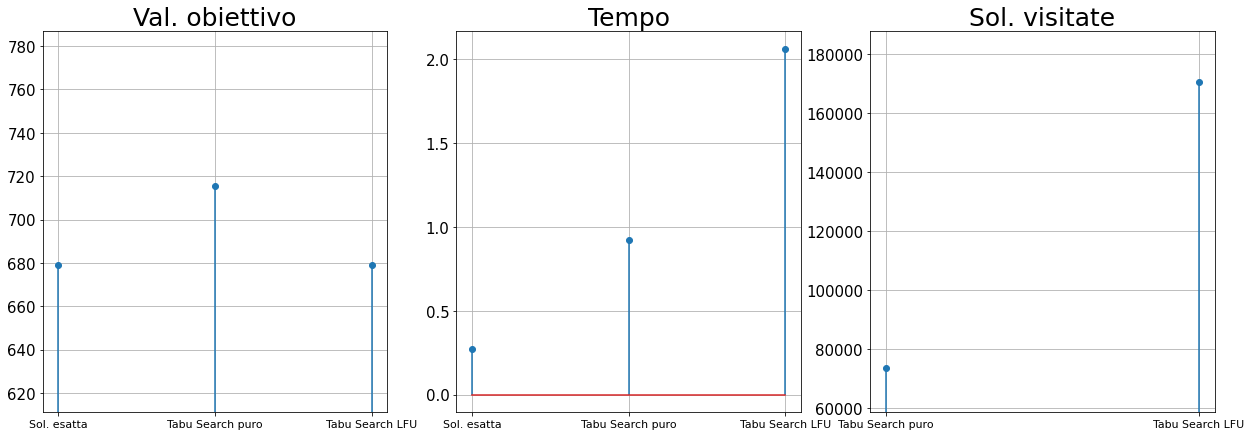

In [16]:
labels = ["Sol. esatta","Tabu Search puro","Tabu Search LFU"]

plt.subplots(1,3,figsize=(21,7))

plt.subplot(1,3,1)
plt.title("Val. obiettivo",fontsize=25)
minimo = min([sol_esatta[1], sol_tabu[1], sol_tabu_LFU[1]])
massimo = max([sol_esatta[1], sol_tabu[1], sol_tabu_LFU[1]])
plt.ylim(minimo * 0.9, massimo * 1.1)
plt.stem([sol_esatta[1], sol_tabu[1], sol_tabu_LFU[1]])
plt.yticks(fontsize = 15)
plt.xticks(range(3), labels, fontsize = 11)
plt.grid(True)

plt.subplot(1,3,2)
plt.title("Tempo",fontsize=25)
plt.stem([runtime, time_execution, time_execution_LFU])
plt.yticks(fontsize = 15)
plt.xticks(range(3), labels, fontsize = 11)
plt.grid(True)

plt.subplot(1,3,3)
plt.title("Sol. visitate",fontsize=25)
minimo = min([sol_visitated, sol_visitated_LFU])
massimo = max([sol_visitated, sol_visitated_LFU])
plt.ylim(minimo * 0.8, massimo * 1.1)
plt.stem([sol_visitated, sol_visitated_LFU])
plt.yticks(fontsize = 15)
plt.xticks(range(2), labels[1:], fontsize = 11)
plt.grid(True)

### Gap per Tabu Search puro

In [17]:
g = calculate_gap(sol_esatta[1],sol_tabu[1])
print(g,"%")

5.318362476055588 %


### Gap per Tabu Search con diversifcazione LFU

In [18]:
g = calculate_gap(sol_esatta[1],sol_tabu_LFU[1])
print(g,"%")

3.347659574607541e-14 %


### Grafico delle soluzioni trovate

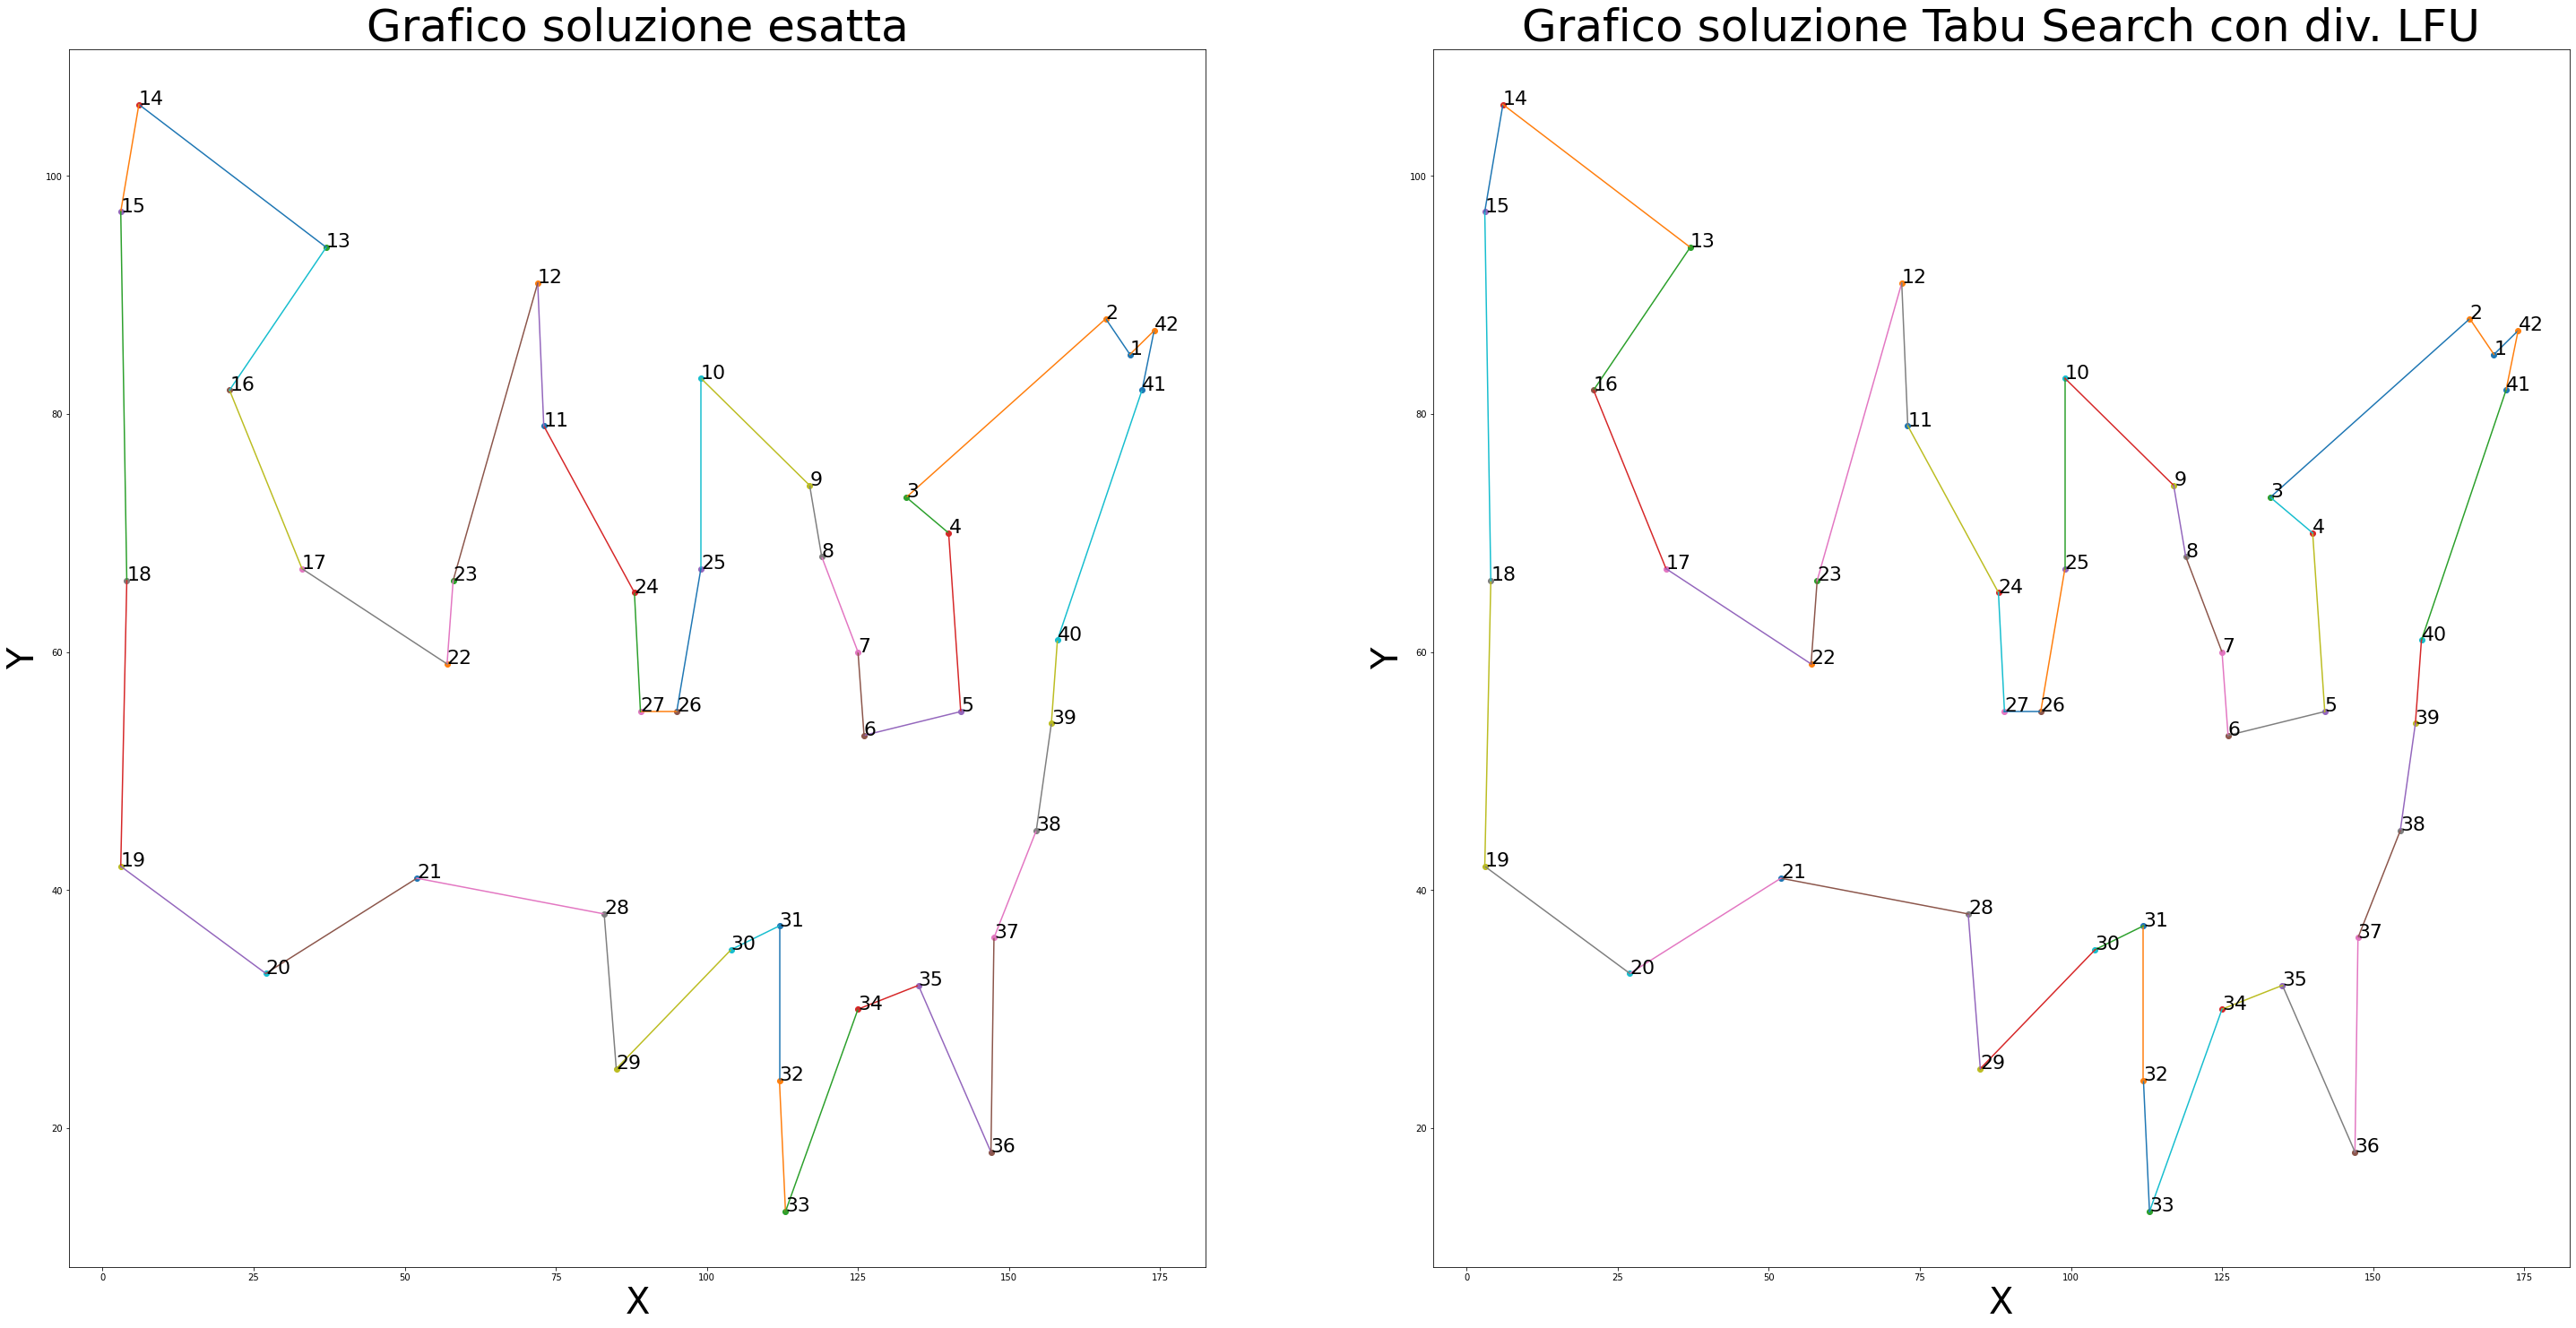

In [19]:
plt.subplots(1,2,figsize=(50,25))
plt.subplot(1,2,1)
plt.title("Grafico soluzione esatta",fontsize=50)
plot_graph(sol_esatta[0])
plt.subplot(1,2,2)
plt.title("Grafico soluzione Tabu Search con div. LFU",fontsize=50)
plot_graph(sol_tabu_LFU[0])

## Tuning dei parametri

###  Grafico per il tuning dei parametri

In [20]:
def plot_params(x_data, y_data, x_label, y_label, x_passo):
    plt.figure(figsize = (30,15))
    plt.xticks(range(min(x_data),max(x_data)+1,x_passo),fontsize = 20)
    plt.yticks(fontsize = 25)
    plt.grid(True)
    plt.xlabel(x_label,fontsize = 50)
    plt.ylabel(y_label,fontsize = 50)
    plt.plot(x_data,y_data,'r')
    plt.show()

### Tabu Search puro

In [21]:
ris = TabuSearch(nodi,dist)

lun_tabu = 21
#num_iter_inc = 31

n_prove = 45
val_iniziale = 1

num_iter_inc = np.array(list(range(val_iniziale,n_prove+val_iniziale)))
#lun_tabu = np.array(list(range(val_iniziale,n_prove+val_iniziale)))


time_execution = np.zeros(n_prove)
g = np.zeros(n_prove)
sol_visitated = np.zeros(n_prove)


for i in range(n_prove):
    start_time = time.process_time()
    sol,sol_vis = ris.resolve(num_iter_inc[i], lun_tabu)
    end_time = time.process_time()
    time_execution[i] = end_time - start_time
    g[i] = calculate_gap(sol_esatta[1],sol[1])
    sol_visitated[i] = sol_vis
    
#print(sum(time_execution)/len(time_execution))

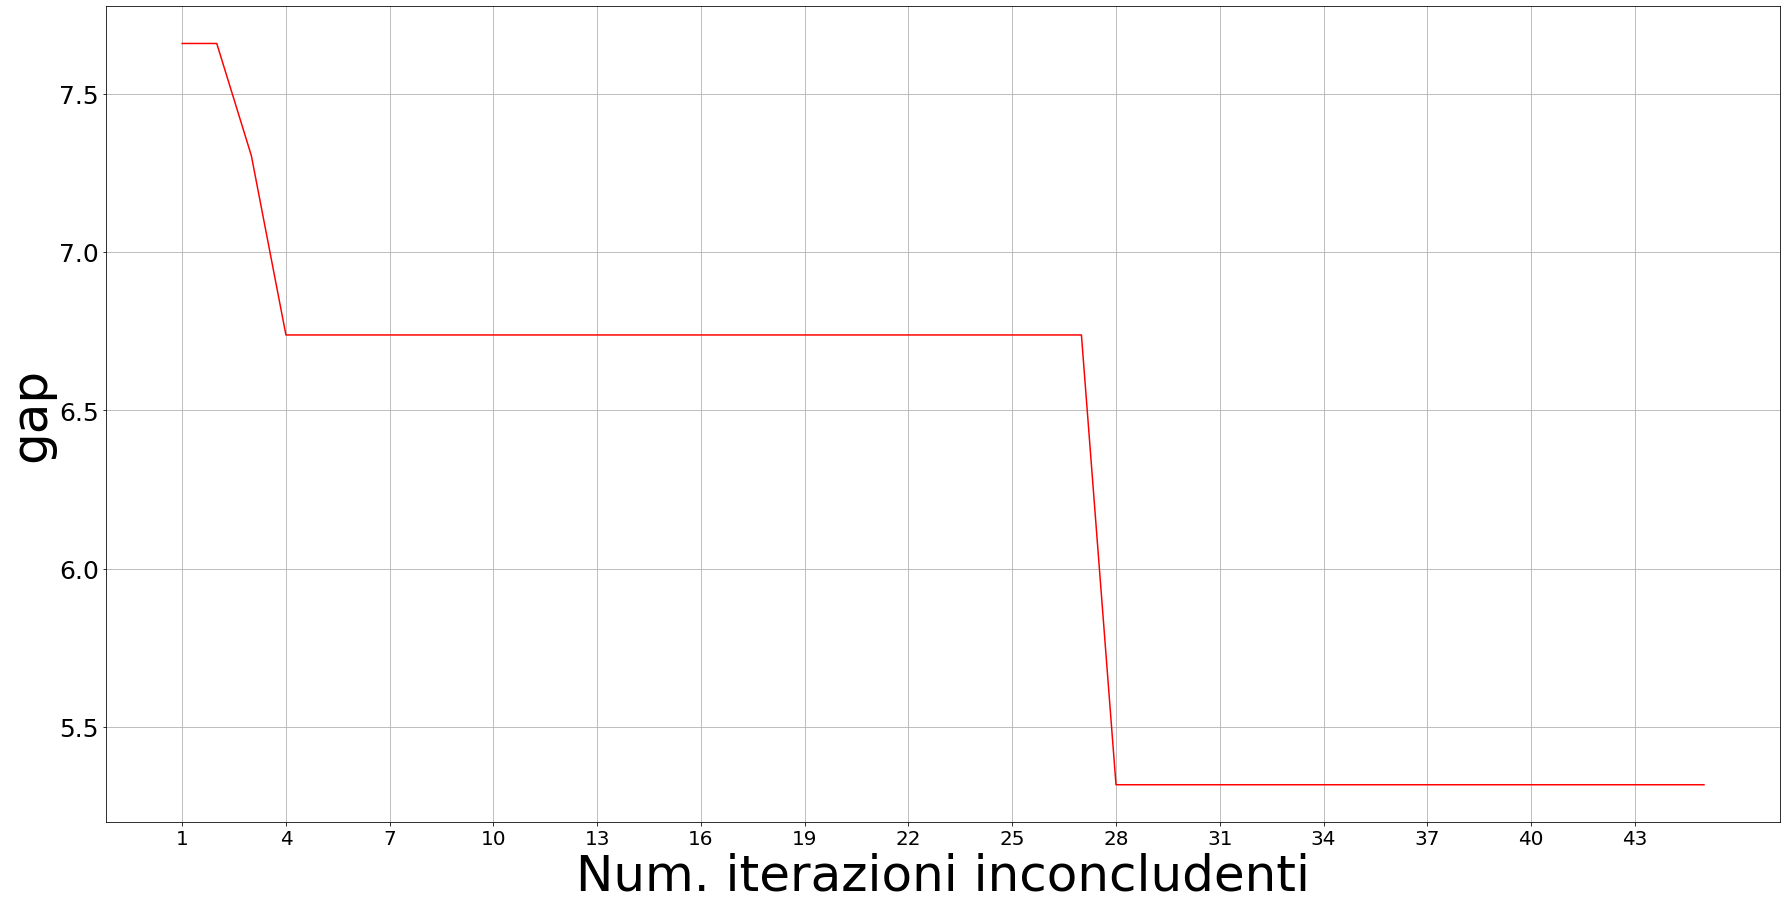

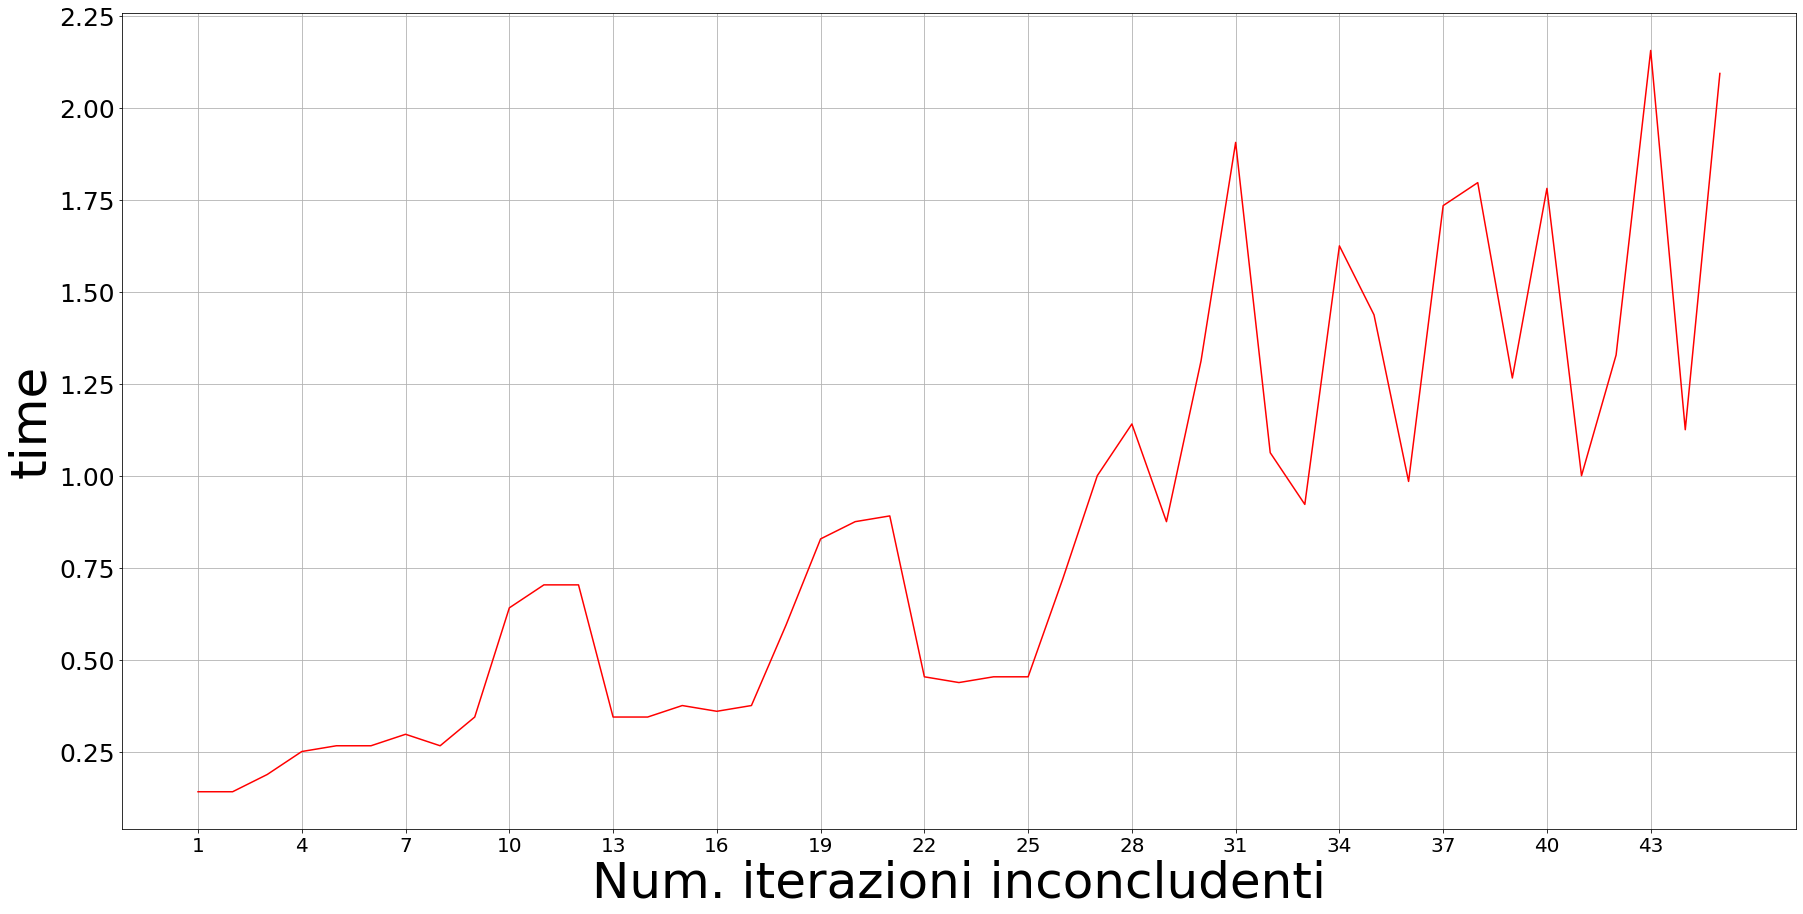

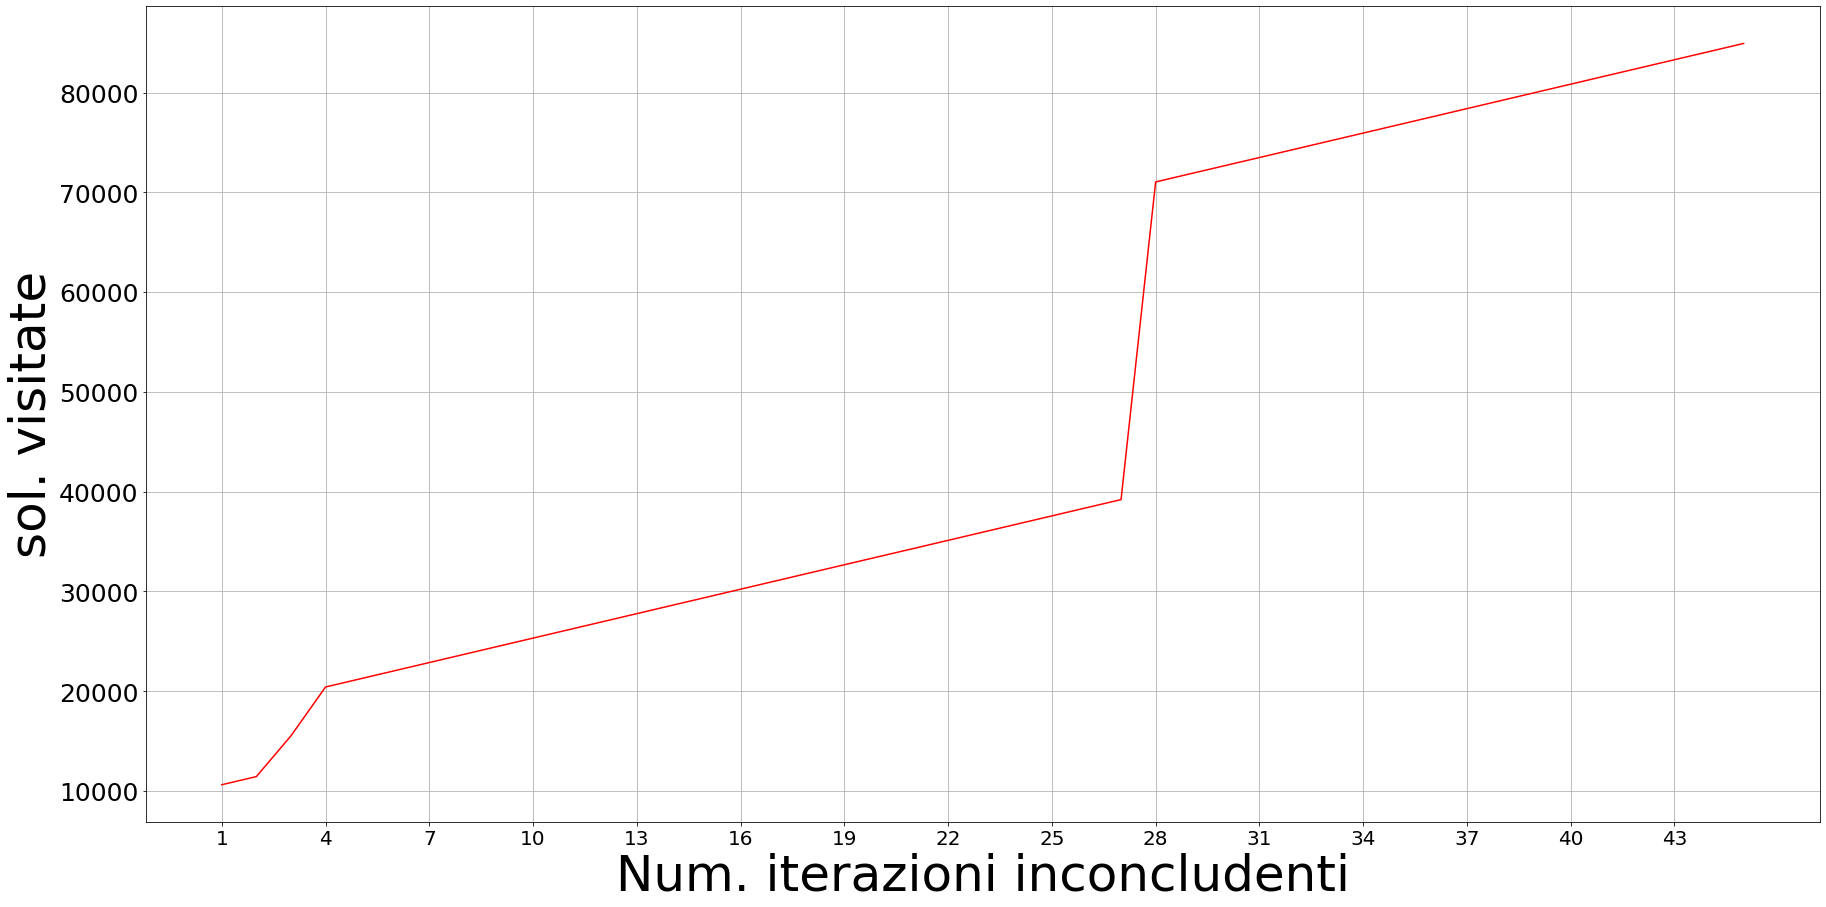

In [22]:
#x_data = np.array(list(range(val_iniziale,n_prove+val_iniziale)))
x_data = num_iter_inc
x_label = "Num. iterazioni inconcludenti"

plot_params(x_data, g, x_label, "gap", 3)
plot_params(x_data, time_execution, x_label, "time", 3)
plot_params(x_data, sol_visitated, x_label, "sol. visitate", 3)

### Tabu Search con diversificazion LFU

In [23]:
ris = TabuSearchLFU(nodi,dist)

lun_tabu =  21
#num_div = 3
num_iter_inc = 35

n_prove = 5
val_iniziale = 0

#n_iter_inc = np.array(list(range(val_iniziale,n_prove+val_iniziale)))
#lun_tabu = np.array(list(range(val_iniziale,n_prove+val_iniziale)))
num_div = np.array(list(range(val_iniziale,n_prove+val_iniziale)))

time_execution = np.zeros(n_prove)
g = np.zeros(n_prove)
sol_visitated = np.zeros(n_prove)

for i in range(n_prove):
    start_time = time.process_time()
    sol,sol_vis = ris.resolve(num_iter_inc, num_div[i], lun_tabu)
    end_time = time.process_time()
    time_execution[i] = end_time - start_time
    g[i] = calculate_gap(sol_esatta[1],sol[1])
    sol_visitated[i] = sol_vis
    
#print(sum(time_execution)/len(time_execution))

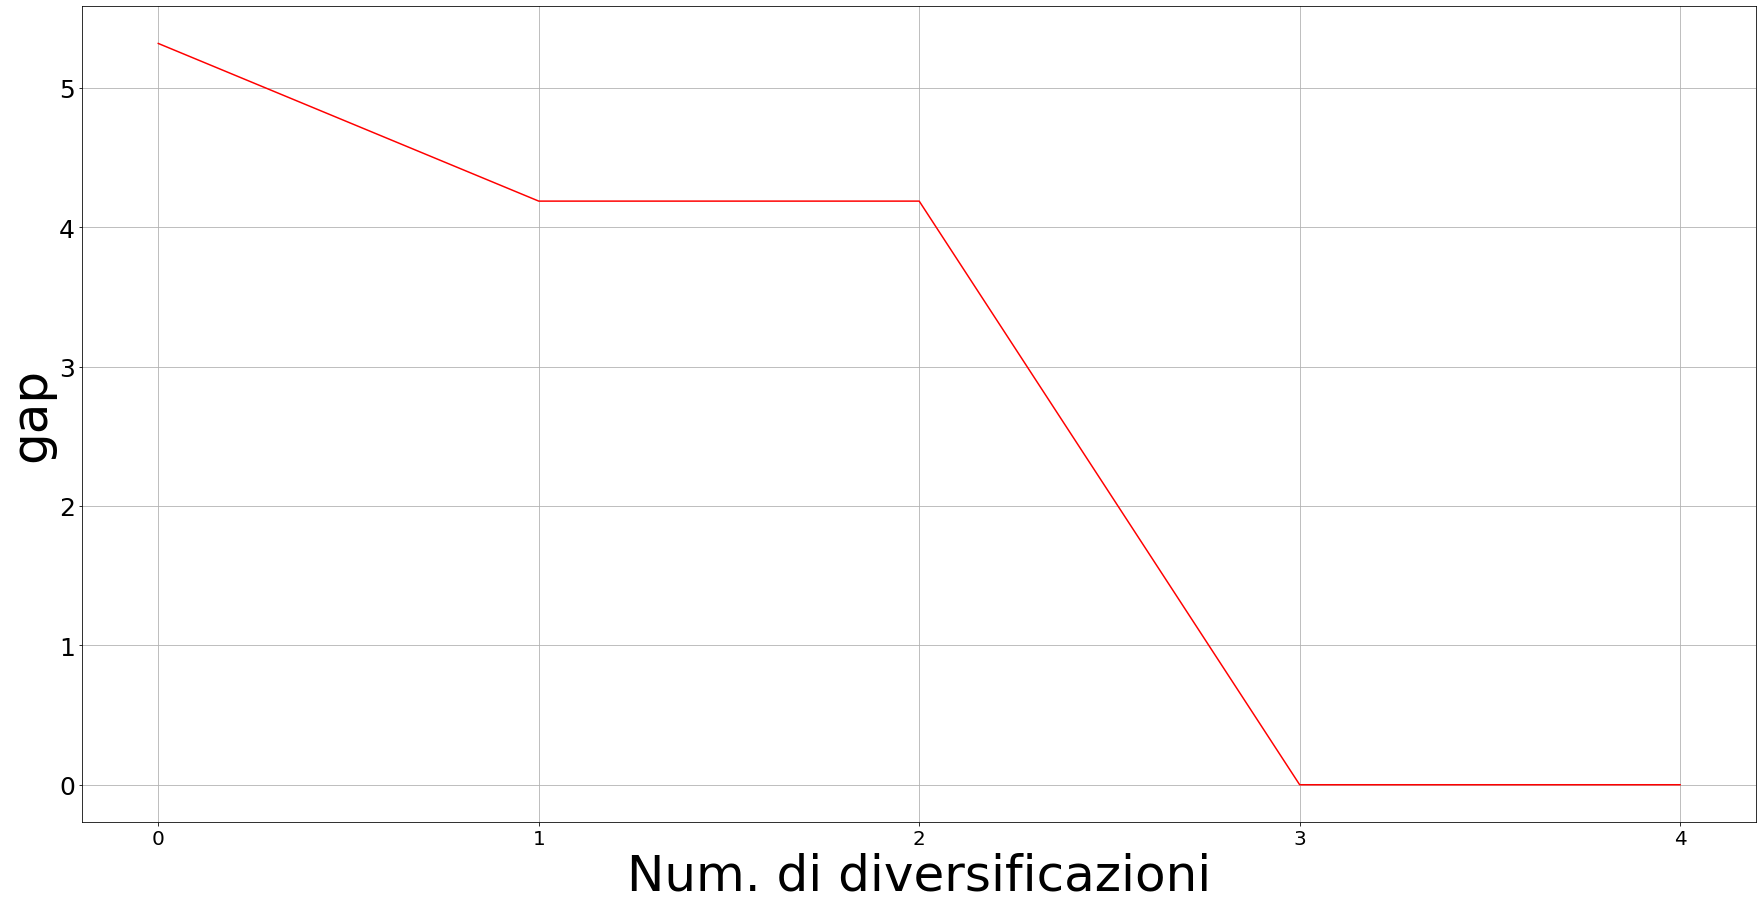

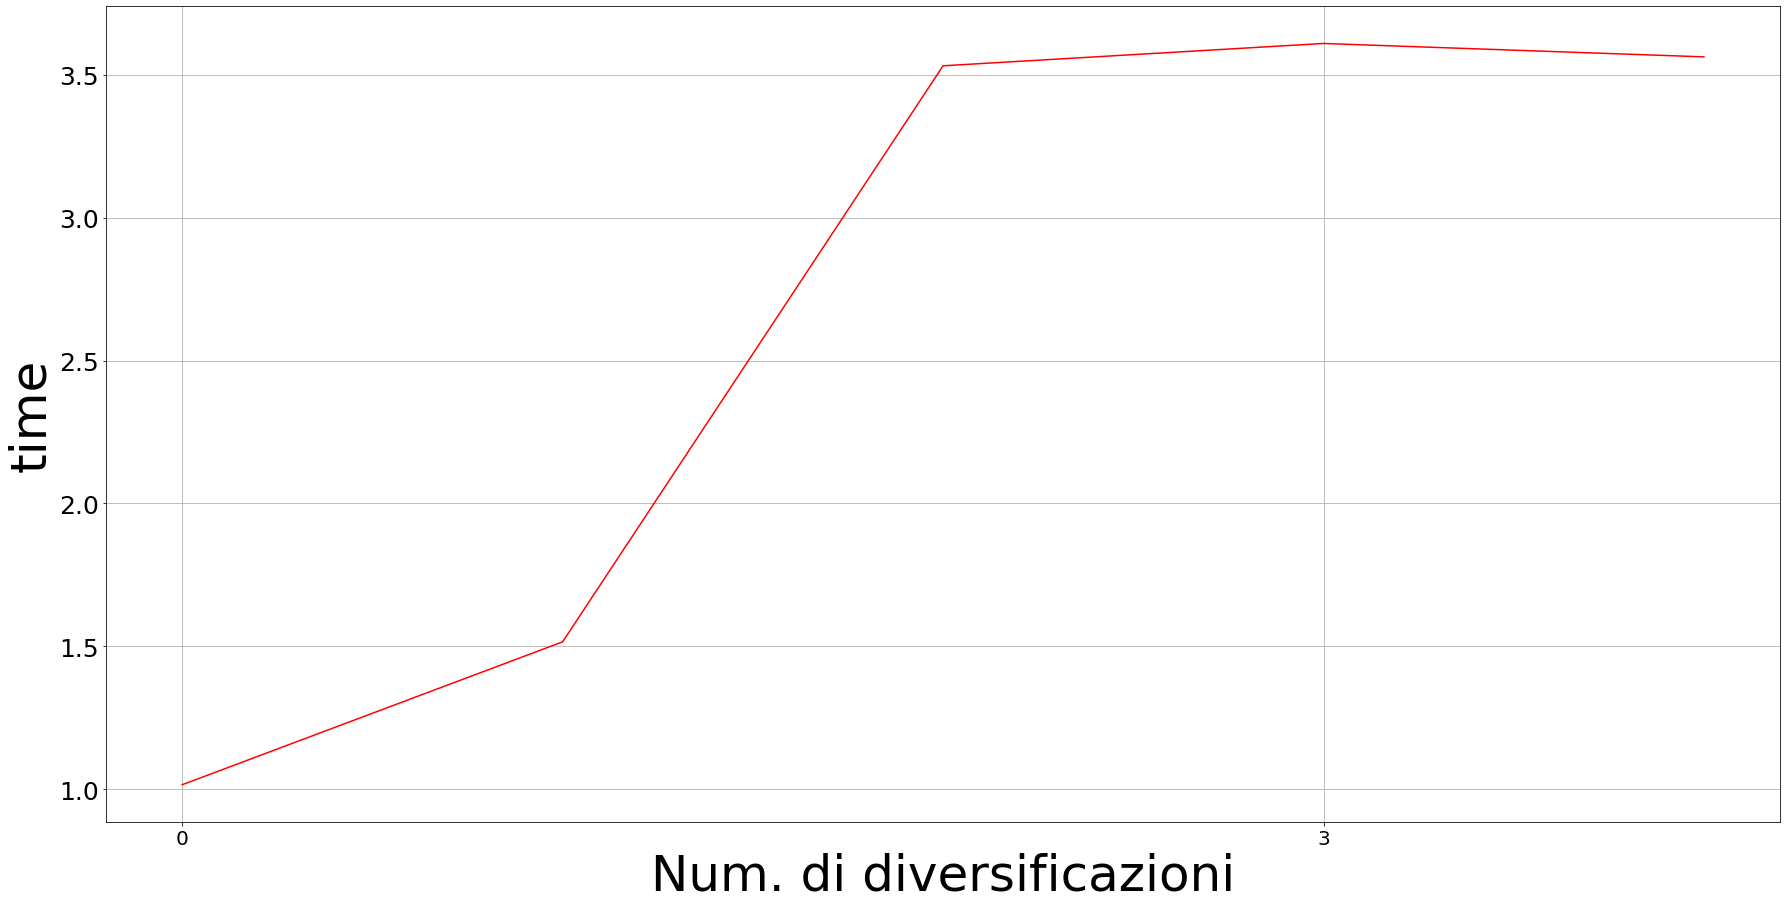

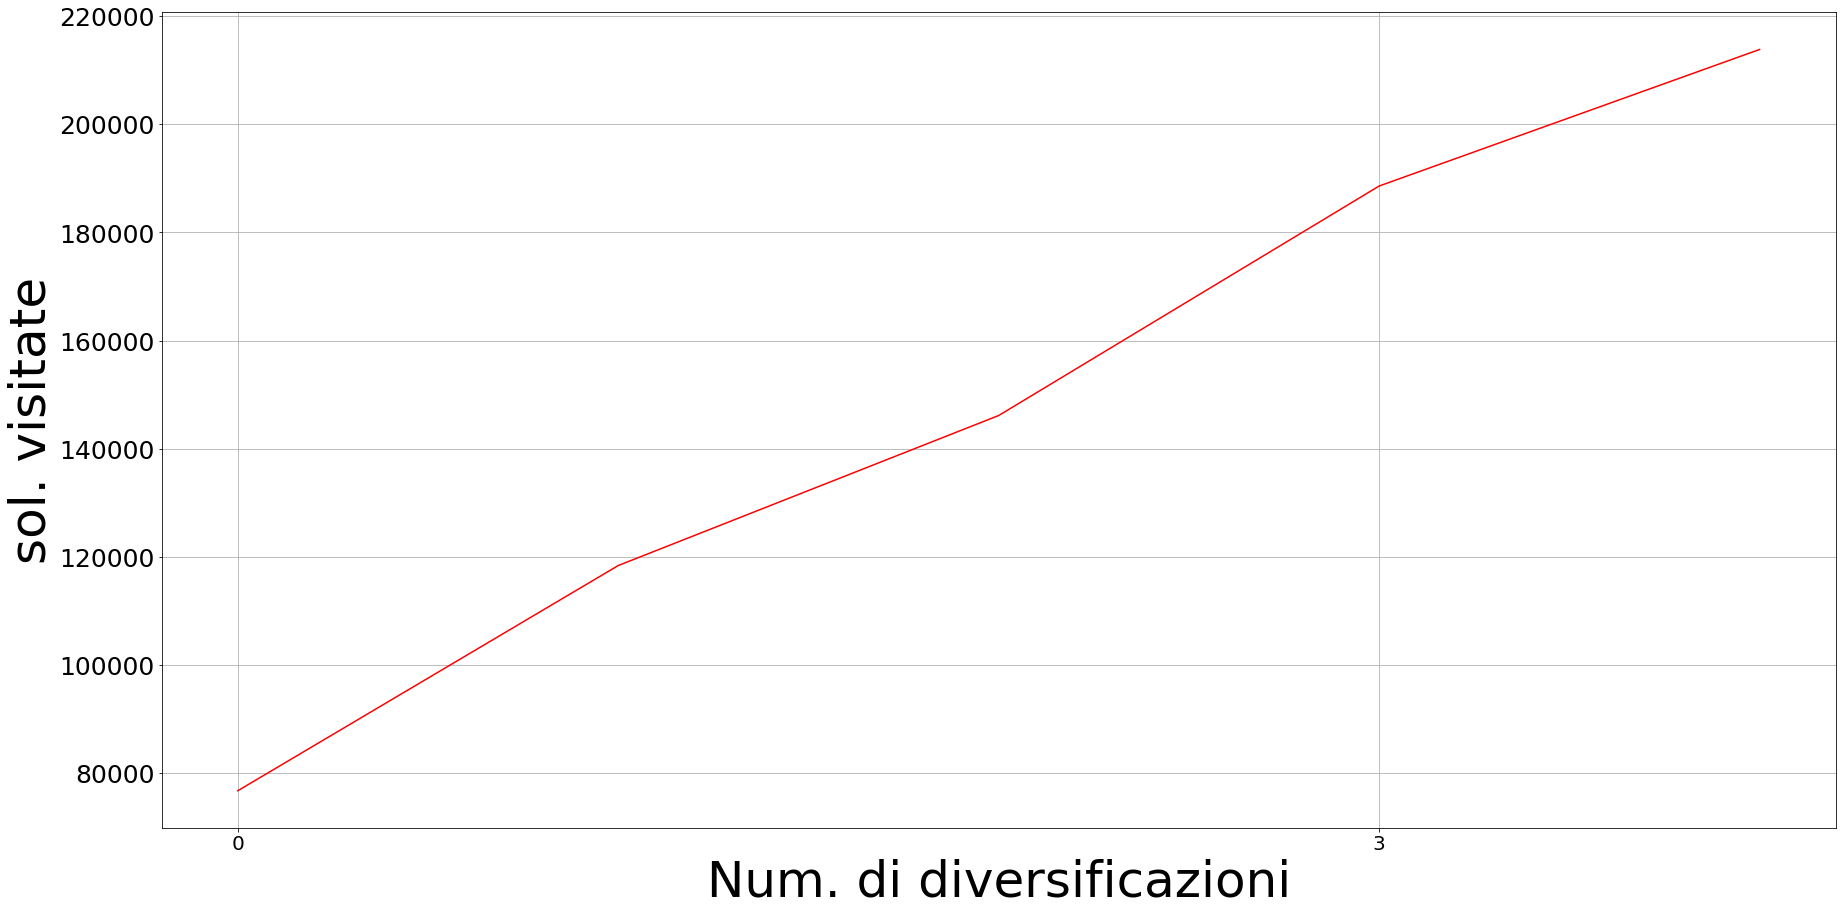

In [24]:
#x_data = np.array(list(range(val_iniziale,n_prove+val_iniziale)))
x_data = num_div
x_label = "Num. di diversificazioni"

plot_params(x_data, g, x_label, "gap", 1)
plot_params(x_data, time_execution, x_label, "time", 3)
plot_params(x_data, sol_visitated, x_label, "sol. visitate", 3)